# Autoencoders: denoising

Type of neural network which typically aims to learn efficient representations (efficient coding) of the data.
Usually autoencoders are trained in an unsupervised manner.


### Applications
1. Anomaly detection
2. Dimensionality reduction
3. Denoising
4. ...

**Reconstruction**
![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
Source: https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

**Denoising**
![denoising](https://miro.medium.com/max/5160/1*SxwRp9i23OM0Up4sEze1QQ@2x.png)
Source: https://www.kaggle.com/tarunkr/autoencoder-denoising-image-mnist-cifar10

## Technical imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## Data

In [ ]:
import torch
from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST

In [ ]:
DATASETS_PATH = 'data' # path to directory where data are to be stored

In [ ]:
transform = transforms.ToTensor()

In [ ]:
mnist_train = MNIST(DATASETS_PATH, train=True, download=True, transform=transform);
mnist_test = MNIST(DATASETS_PATH, train=False, download=True, transform=transform);

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
batch_size = 128
mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [ ]:
img = mnist_train[0][0]

Salt and pepper transform:

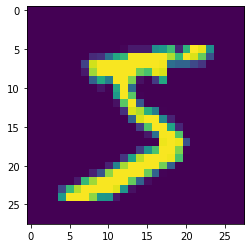

In [ ]:
plt.imshow(img[0])

In [ ]:
img.size()

torch.Size([1, 28, 28])

In [ ]:
batch = next(iter(mnist_train_dataloader))

In [ ]:
batch[0].shape

torch.Size([128, 1, 28, 28])

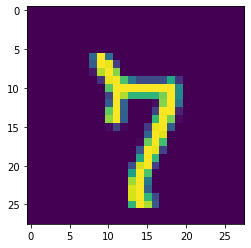

In [ ]:
plt.imshow(batch[0][0][0])

In [ ]:
def salt_and_pepper(img, noise):
    """img: tensor of size 1 x H x W"
    noise: salt and pepper fraction"""
    # copy tensor
    img_out = img.clone()
    
    N_pixels = img_out.shape[1] * img_out.shape[2]
    # randomly sample indices for salt and pepper
    indices_salt = np.random.choice(np.arange(N_pixels), int(0.5*noise*N_pixels))
    indices_pepper = np.random.choice(np.arange(N_pixels), int(0.5*noise*N_pixels))
    # apply salt and pepper
    img_out[np.unravel_index(indices_salt, img_out.shape)] = 0.0
    img_out[np.unravel_index(indices_pepper, img_out.shape)] = 1.0
    return img_out

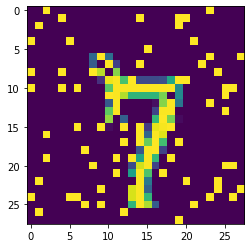

In [ ]:
plt.imshow(salt_and_pepper(batch[0][0], 0.2)[0])

In [ ]:
class SaltPepper:
    def __init__(self, noise):
        self.noise = noise
    
    def __call__(self, img_or_batch):
        if img_or_batch.ndim == 3:
            is_image=True
            img_or_batch = img_or_batch.unsqueeze(0) # produce "batch" of length 1
        else:
            is_image=False
        
        batch_out = img_or_batch.clone()
    
        N_pixels = batch_out.shape[0] * batch_out.shape[2] * batch_out.shape[3]
        # randomly sample indices for salt and pepper
        indices_salt = np.random.choice(np.arange(N_pixels), int(0.5*self.noise*N_pixels))
        indices_pepper = np.random.choice(np.arange(N_pixels), int(0.5*self.noise*N_pixels))
        # apply salt and pepper
        batch_out[np.unravel_index(indices_salt, batch_out.shape)] = 0.0
        batch_out[np.unravel_index(indices_pepper, batch_out.shape)] = 1.0
        
        if is_image:
            return batch_out.squeeze(0) # return image shape
    
        return batch_out

In [ ]:
noise_level = 0.2
salt_pepper_transform = SaltPepper(noise_level)

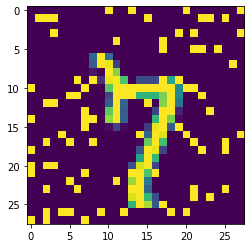

In [ ]:
plt.imshow(salt_pepper_transform(batch[0])[0][0], vmin=0, vmax=1)

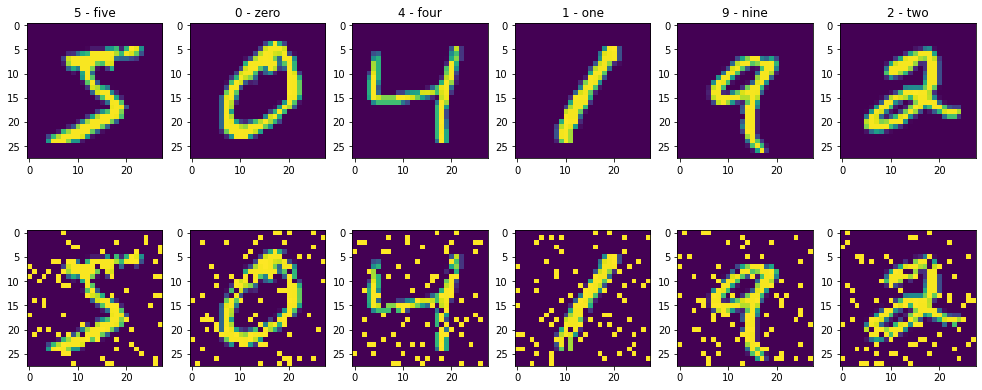

In [ ]:
num_images = 6
fig, axs = plt.subplots(ncols=num_images, nrows=2, figsize=(17,7))
for i in range(num_images):
    img, target = mnist_train[i]
    axs[0][i].imshow(img[0])
    axs[0][i].set_title(f'{mnist_train.classes[target]}')
    axs[1][i].imshow(salt_pepper_transform(img)[0])
    
    

## Model

In [ ]:
import torch
from torch import nn

In [ ]:
class Encoder_1hl(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        """
        hidden_dim: number of neurons in the hidden layer
        latent_dim: number of latent space dimensions
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            )

    def forward(self, x):
        x = self.net(x)
        return x

In [ ]:
class Decoder_1hl(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        """
        hidden_dim: number of neurons in the hidden layer
        latent_dim: number of latent space dimensions
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 28*28),
            nn.Sigmoid() # sigmoid function transforms input values (-inf, +inf) to output in range (0, 1)
            )
            

    def forward(self, x):
        x = self.net(x)
        return x

In [ ]:
class Autoencoder_1hl(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        """
        hidden_dim: number of neurons in the hidden layer
        latent_dim: number of latent space dimensions
        """
        super().__init__()
        self.encoder = Encoder_1hl(hidden_dim, latent_dim)
        self.decoder = Decoder_1hl(hidden_dim, latent_dim)
            
    def forward(self, x):
        input_shape = x.shape #batch_size, channels, height, width
        x = x.view(input_shape[0], -1)
        x = self.encoder(x)
        x = self.decoder(x) 
        return x.view(input_shape)

In [ ]:
hidden_dim = 64
latent_dim = 12

In [ ]:
autoencoder = Autoencoder_1hl(hidden_dim, latent_dim)

## Training

In [ ]:
distortion = SaltPepper(noise_level)

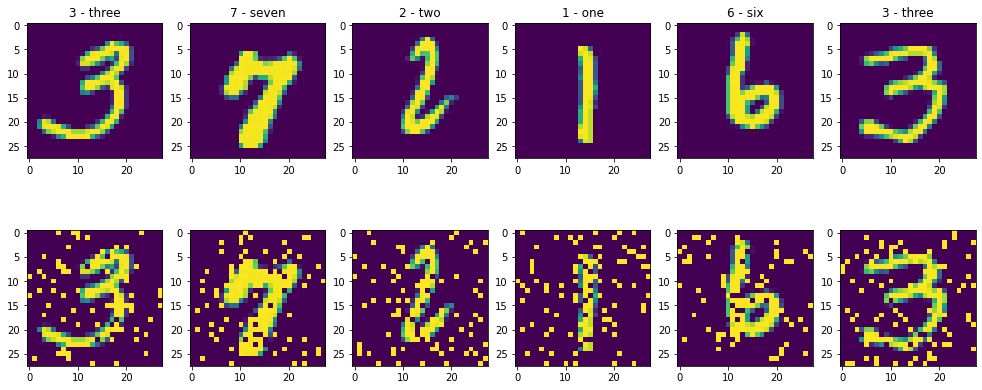

In [ ]:
x, y = next(iter(mnist_train_dataloader))
x_distorted = distortion(x)
num_images = 6
fig, axs = plt.subplots(ncols=num_images, nrows=2, figsize=(17,7))
for i in range(num_images):
    axs[0][i].imshow(x[i][0])
    axs[0][i].set_title(f'{mnist_train.classes[y[i]]}')
    axs[1][i].imshow(x_distorted[i][0])


In [1]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # if your machine supports cuda, it wil be used for computation
autoencoder.to(device).train();
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

NameError: name 'torch' is not defined

#### Your task
Can you modify the training loop, so that the model will be train to reconstruct image before distortion?

In [ ]:
num_epochs = 2

history = [] #save losses from each epoch
for i_epoch in range(num_epochs):
    epoch_losses = []
    for batch in mnist_train_dataloader:
         # clear gradient from previous step
        optimizer.zero_grad()
        
        x, y = batch
        # your code here
        ...
        loss = ...
        
        # compute accumulated gradients
        loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # save loss
        epoch_losses.append(loss.item()) #'item()' gets number from tensor. Similarly 'numpy()' returns numpy array copy of the tensor
        
        
    epoch_loss = np.mean(epoch_losses)
    print(f'epoch {i_epoch}, loss: {epoch_loss:0.4f}')
    history.append({'loss': epoch_loss})
        

epoch 0, loss: 0.0239
epoch 1, loss: 0.0236


In [ ]:
@torch.no_grad()
def evaluate_model(model, dataloader, criterion, distortion, device=device):
    losses = []
    model = model.eval()
    for batch in dataloader:  
        x, y = batch
        x = x.to(device)
        x_hat = autoencoder(distortion(x))
        loss = criterion(x, x_hat)
        losses.append(loss.item())
    final_loss = np.mean(losses)
    return final_loss

Test if your function works

In [ ]:
test_loss = evaluate_model(autoencoder, mnist_test_dataloader, criterion, distortion)
print(f'test loss: {test_loss:0.4f}')

test loss: 0.0318


Now we are ready to implement testset evaluation and do the proper traing of the model. For clarity, let's create a fresh autoencoder

In [ ]:
hidden_dim = 64
latent_dim = 12
autoencoder = Autoencoder_1hl(hidden_dim, latent_dim)
autoencoder.to(device).train();

optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=1e-3)

In [ ]:
num_epochs = 10

history = [] #save losses from each epoch
for i_epoch in range(num_epochs):
    epoch_losses = []
    for batch in mnist_train_dataloader:
         # clear gradient from previous step
        optimizer.zero_grad()
        
        x, y = batch
        x = x.to(device)
        x_hat = autoencoder(distortion(x))
        loss = criterion(x, x_hat)
        
        # compute accumulated gradients
        loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # save loss
        epoch_losses.append(loss.item()) #'item()' gets number from tensor. Similarly 'numpy()' returns numpy array copy of the tensor
        
        
    epoch_loss = np.mean(epoch_losses)
    test_loss = evaluate_model(autoencoder, mnist_test_dataloader, criterion, distortion)
    autoencoder.train() # if "evaluate_model" switches the model to 'eval' mode, switch it back 'train'
    print(f'epoch {i_epoch}, train loss: {epoch_loss:0.4f}, test loss {test_loss:0.4f}')
    history.append({'train loss': epoch_loss, 'test loss': test_loss})
        

epoch 0, train loss: 0.0629, test loss 0.0415
epoch 1, train loss: 0.0355, test loss 0.0313
epoch 2, train loss: 0.0304, test loss 0.0287
epoch 3, train loss: 0.0284, test loss 0.0271
epoch 4, train loss: 0.0271, test loss 0.0261
epoch 5, train loss: 0.0261, test loss 0.0253
epoch 6, train loss: 0.0254, test loss 0.0247
epoch 7, train loss: 0.0249, test loss 0.0241
epoch 8, train loss: 0.0245, test loss 0.0238
epoch 9, train loss: 0.0242, test loss 0.0236


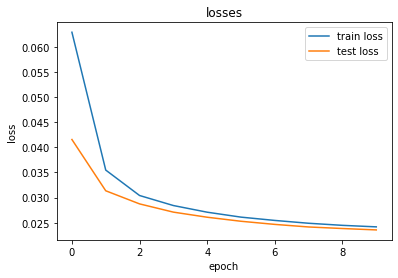

In [ ]:
plt.plot([entry['train loss'] for entry in history], label='train loss')
plt.plot([entry['test loss'] for entry in history], label='test loss')
plt.title('losses');
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

For inference on small samples, we can use CPU - it allows to not care about 'cuda' stuff. If the models or images are large, better stay with GPU.

In [ ]:
autoencoder.to('cpu').eval();

In [ ]:
def reconstruct_image(img, model):
    with torch.no_grad():
        return model(img.unsqueeze(0))[0]

In [ ]:
img, target = mnist_test[0]
img_distorted = distortion(img.unsqueeze(0)).squeeze(0)
reconstruction = reconstruct_image(img_distorted, autoencoder)

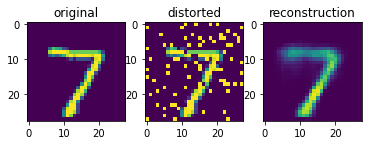

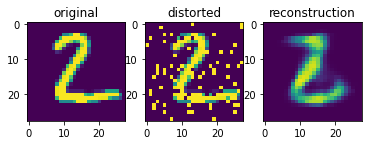

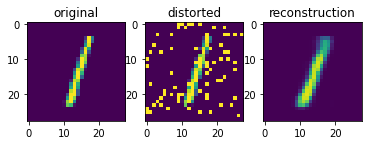

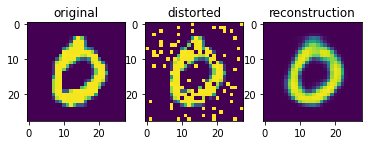

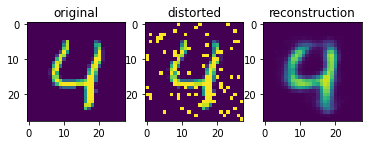

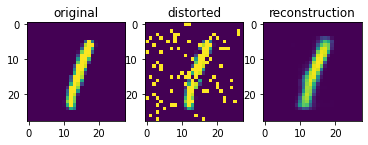

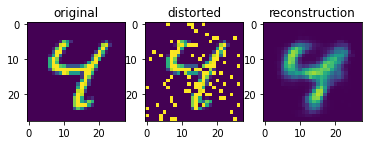

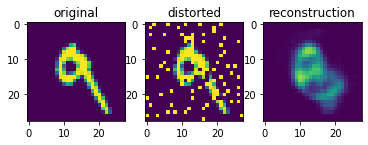

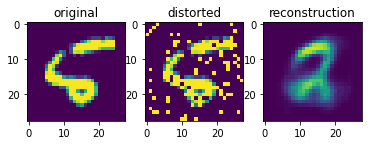

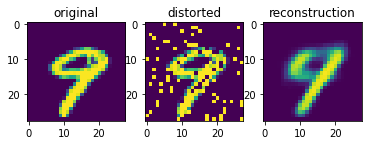

In [ ]:
for i in range(10):
    img, target = mnist_test[i]
    img_distorted = distortion(img.unsqueeze(0)).squeeze(0)
    reconstruction = reconstruct_image(img_distorted, autoencoder)
    fig, axs = plt.subplots(ncols=3)
    axs[0].imshow(img[0], vmin=0, vmax=1)
    axs[0].set_title('original')
    axs[1].imshow(img_distorted[0], vmin=0, vmax=1)
    axs[1].set_title('distorted')
    axs[2].imshow(reconstruction[0], vmin=0, vmax=1)
    axs[2].set_title('reconstruction')

## Robustness to noise

In [ ]:
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

In [ ]:
autoencoder = autoencoder.to(device);

In [ ]:
loss_for_noise = {}
for noise_level in noise_levels:
    distortion = SaltPepper(noise_level)
    loss_for_noise[noise_level] = evaluate_model(autoencoder, mnist_test_dataloader, criterion, distortion)

In [ ]:
for noise_level, loss in loss_for_noise.items():
    print(f'noise: {noise_level}, loss: {loss:0.4f}')

noise: 0.0, loss: 0.0220
noise: 0.1, loss: 0.0221
noise: 0.2, loss: 0.0231
noise: 0.3, loss: 0.0252
noise: 0.4, loss: 0.0284
noise: 0.5, loss: 0.0328


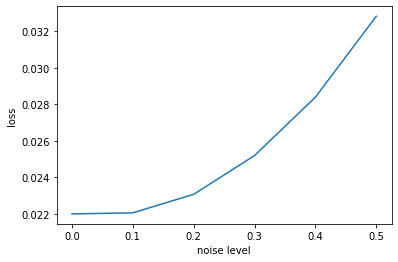

In [ ]:
plt.plot(noise_levels, [loss_for_noise[noise] for noise in noise_levels]);
plt.xlabel('noise level');
plt.ylabel('loss');

Now let's try robustness to Gaussian noise, for which the model wasn't trained for

In [ ]:
class GaussianNoise:
    def __init__(self, noise):
        self.noise = noise
    
    def __call__(self, img_or_batch):
        if img_or_batch.ndim == 3:
            is_image=True
            img_or_batch = img_or_batch.unsqueeze(0) # produce "batch" of length 1
        else:
            is_image=False
        
        batch_out = img_or_batch.clone()
        
        noise = torch.randn(batch_out.shape) * self.noise #create noise sampled from normal distribution
        
        batch_out = batch_out + noise.to(batch_out) # add noise
        batch_out = torch.clip(batch_out, 0, 1) #keep values between 0 and 1
        
        if is_image:
            return batch_out.squeeze(0) # return image shape
    
        return batch_out
    

Test Gaussian distortion:

In [ ]:
gaussian_distorition = GaussianNoise(0.1)
batch = next(iter(mnist_train_dataloader))

In [ ]:
img = batch[0][0]
distorted_image = gaussian_distorition(img)

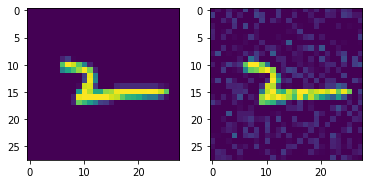

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(img[0])
ax2.imshow(distorted_image[0])

In [ ]:
gaussian_loss_for_noise = {}
for noise_level in noise_levels:
    distortion = GaussianNoise(noise_level)
    gaussian_loss_for_noise[noise_level] = evaluate_model(autoencoder, mnist_test_dataloader, criterion, distortion)

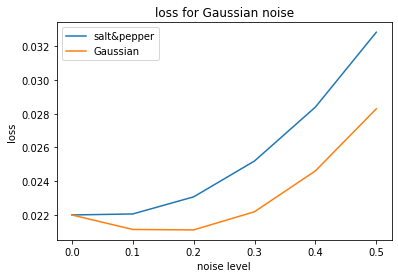

In [ ]:
plt.plot(noise_levels, [loss_for_noise[noise] for noise in noise_levels], label='salt&pepper');
plt.plot(noise_levels, [gaussian_loss_for_noise[noise] for noise in noise_levels], label='Gaussian');
plt.xlabel('noise level');
plt.ylabel('loss');
plt.title('loss for Gaussian noise');
plt.legend();